In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import cv2 as cv
%matplotlib inline

from src.guided_filter import average_filter, average_filter_multichannel, guided_filter_with_colored_guide_v1, guided_filter_with_colored_guide_v2

In [2]:
%load_ext autoreload
%autoreload 2

# Utilitary functions

In [3]:
def show_images(im1, im2, title1, title2, gray=False):
    _, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(im1, cmap='gray' if gray else None)
    axes[0].axis('off')
    axes[0].set_title(f'Cathedral 1: {title1}')
    axes[1].imshow(im2, cmap='gray' if gray else None)
    axes[1].axis('off')
    axes[1].set_title(f'Cathedral 2: {title2}')

In [4]:
# To convert image to grayscale
def rgb2gray(rgb, use_opencv=False): 
    if use_opencv:
     return cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)
    else:
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])  # Chosen to comply with OpenCV, see https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

# Import images

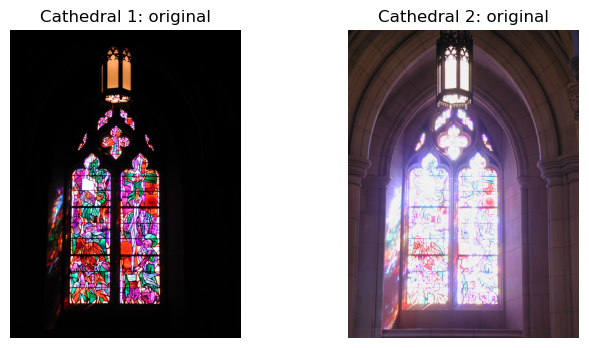

In [5]:
im1 = plt.imread("dataset/cathedral1.jpg")
im2 = plt.imread("dataset/cathedral2.jpg")
show_images(im1, im2, 'original', 'original')

# Image fusion with guided filtering

## Two-scale image decomposition

### Option 1 - Faster

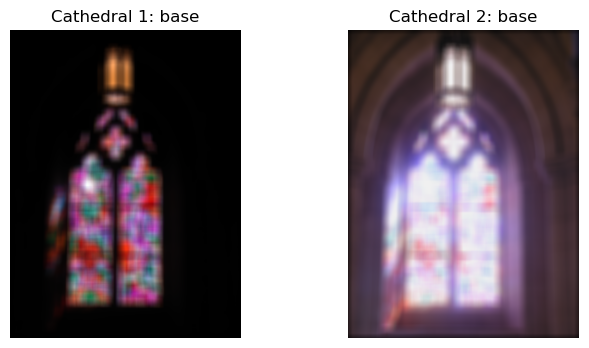

In [6]:
# Compute base layers
# Parameters
average_filter_size = 31

# For an average filter, we can apply the filter to each color channel separately
base1 = average_filter_multichannel(im1, average_filter_size).astype(int)
base2 = average_filter_multichannel(im2, average_filter_size).astype(int)
    
# Plot results
show_images(base1, base2, 'base', 'base')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


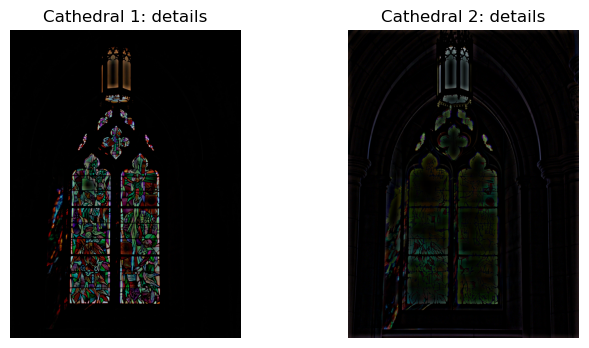

In [7]:
# Compute details layers
detail1 = im1 - base1  # Remark: how to interpret negative values?
detail2 = im2 - base2
    
# Plot results
show_images(detail1, detail2, 'details', 'details')

# Option 2: slower

In [8]:
# # Compute base layers
# # Parameters
# average_filter_size = 31
# average_filter = np.ones((average_filter_size, average_filter_size)) / average_filter_size**2

# # For an average filter, we can apply the filter to each color channel separately
# base1 = np.zeros_like(im1)
# base2 = np.zeros_like(im2)
# for i in range(3):
#     base1[:,:,i] = convolve2d(im1[:,:,i], average_filter, mode='same')
#     base2[:,:,i] = convolve2d(im2[:,:,i], average_filter, mode='same')
    
# # Plot results
# show_images(base1, base2, 'base', 'base')

In [9]:
# # Compute details layers
# detail1 = im1 - base1
# detail2 = im2 - base2
    
# # Plot results
# show_images(detail1, detail2, 'details', 'details')

## Weight Map Construction With Guided Filtering

### Apply Laplacian filter

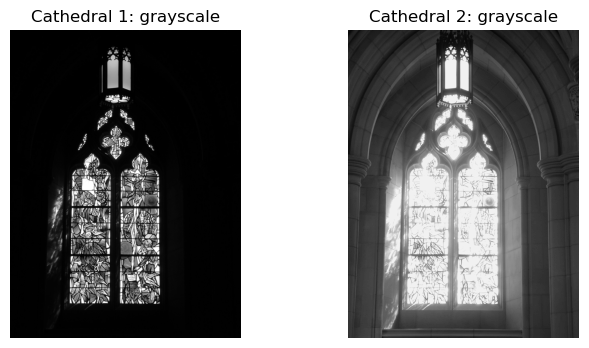

In [10]:
# We will convert images to grayscale to apply Laplacian filter
show_images(rgb2gray(im1), rgb2gray(im2), 'grayscale', 'grayscale', gray=True)

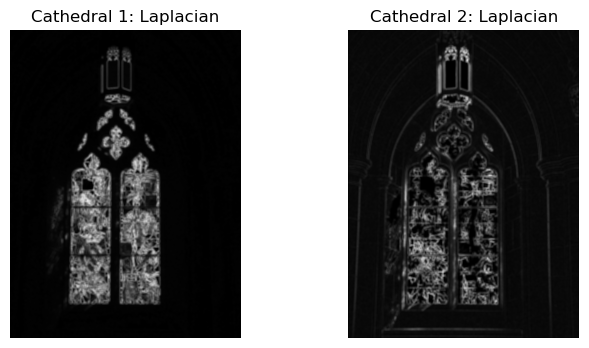

In [11]:
# Declare the variables we are going to use
ddepth = -1
kernel_size = 3
sigma = 0  # ?
local_average_size = 7

# Image 1
im1_blur = cv.GaussianBlur(im1, (kernel_size, kernel_size), sigma)
im1_gray = cv.cvtColor(im1_blur, cv.COLOR_RGB2GRAY)
H1 = cv.Laplacian(im1_gray, ddepth, ksize=kernel_size)
H1 = cv.convertScaleAbs(H1)
H1 = average_filter(H1, local_average_size)  # Take local average of the absolute value
# Image 2
im2_blur = cv.GaussianBlur(im2, (kernel_size, kernel_size), sigma)
im2_gray = cv.cvtColor(im2_blur, cv.COLOR_RGB2GRAY)
H2 = cv.Laplacian(im2_gray, ddepth, ksize=kernel_size)
H2 = cv.convertScaleAbs(H2)
H2 = average_filter(H2, local_average_size)

# Show images
show_images(H1, H2, 'Laplacian', 'Laplacian', gray=True)

### Apply low-pass Gaussian filter

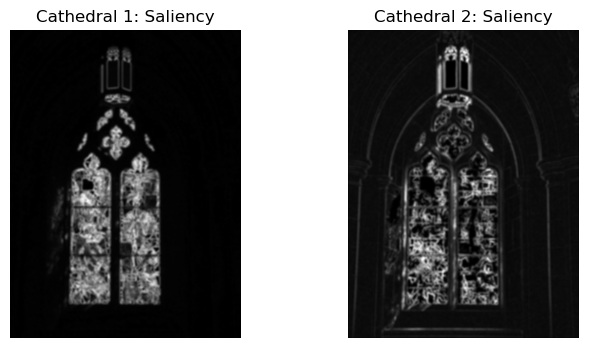

In [12]:
# Parameters
sigma = 5 # Standard deviation of the Gaussian kernel
radius = 5 # Radius of the Gaussian filter

# Compute saliency maps
saliency1 = gaussian_filter(H1, sigma=sigma, radius=radius)
saliency2 = gaussian_filter(H2, sigma=sigma, radius=radius)
show_images(saliency1, saliency2, 'Saliency', 'Saliency', gray=True)

### Get weight masks by saliency comparison

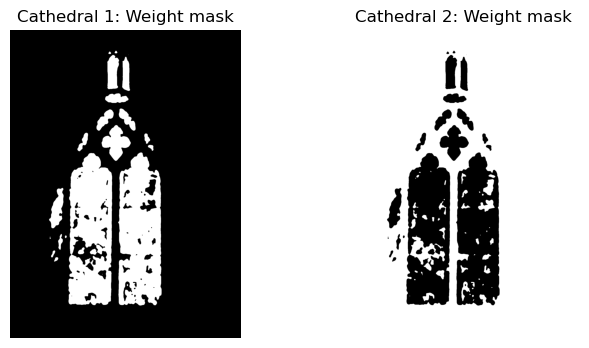

In [27]:
# Here implemented for only 2 images
P1 = (saliency1 >= saliency2).astype(int)
P2 = 1 - P1
show_images(P1, P2, 'Weight mask', 'Weight mask', gray=True)

### Guided Filtering on weight masks to obtain spatial consistency

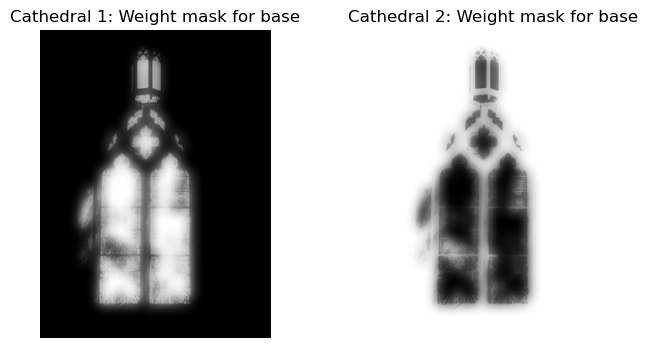

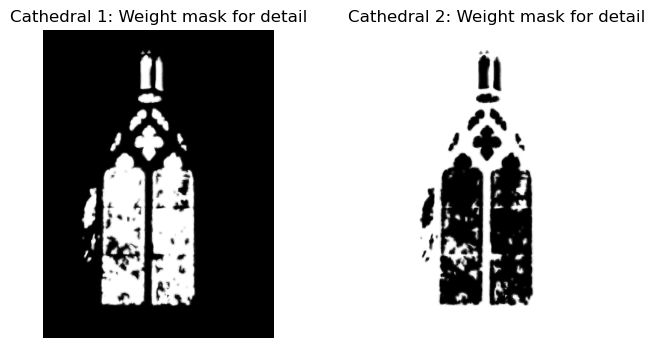

In [14]:
r1 = 45
r2 = 7
eps1 = 0.3
eps2 = 1e-6
W1B = np.clip(guided_filter_with_colored_guide_v2(P1, (im1/255).astype(np.float32), r1, eps1), 0, None)
W2B = np.clip(guided_filter_with_colored_guide_v2(P2, (im2/255).astype(np.float32), r1, eps1), 0, None)
W1B = W1B / (W1B + W2B)
W2B = W2B / (W1B + W2B)
show_images(W1B, W2B, 'Weight mask for base', 'Weight mask for base', gray=True)
W1D = np.clip(guided_filter_with_colored_guide_v2(P1, (im1/255).astype(np.float32), r2, eps2), 0, None)
W2D = np.clip(guided_filter_with_colored_guide_v2(P2, (im2/255).astype(np.float32), r2, eps2), 0, None)
W1D = W1D / (W1D + W2D)
W2D = W2D / (W1D + W2D)
show_images(W1D, W2D, 'Weight mask for detail', 'Weight mask for detail', gray=True)

In [15]:
# r1 = 45
# r2 = 7
# eps1 = 0.3
# eps2 = 1e-6
# W1B = np.clip(guided_filter_with_colored_guide_v1(P1, (im1/255).astype(np.float32), r1, eps1), 0, None)
# W2B = np.clip(guided_filter_with_colored_guide_v1(P2, (im2/255).astype(np.float32), r1, eps1), 0, None)
# W1B = W1B / (W1B + W2B)
# W2B = W2B / (W1B + W2B)
# show_images(W1B, W2B, 'Weight mask for base', 'Weight mask for base', gray=True)
# W1D = np.clip(guided_filter_with_colored_guide_v1(P1, (im1/255).astype(np.float32), r2, eps2), 0, None)
# W2D = np.clip(guided_filter_with_colored_guide_v1(P2, (im2/255).astype(np.float32), r2, eps2), 0, None)
# W1D = W1D / (W1D + W2D)
# W2D = W2D / (W1D + W2D)
# show_images(W1D, W2D, 'Weight mask for detail', 'Weight mask for detail', gray=True)

#### Guided filter from opencv

C:\Users\Theilo\AppData\Local\Temp\ipykernel_22072\3807995336.py:16: RuntimeWarning: invalid value encountered in divide
  W1B = W1B / (W1B + W2B)


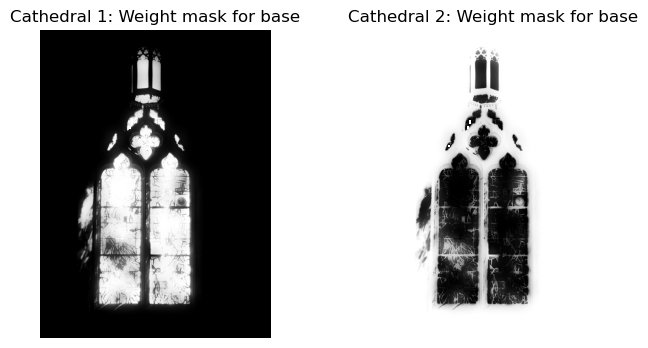

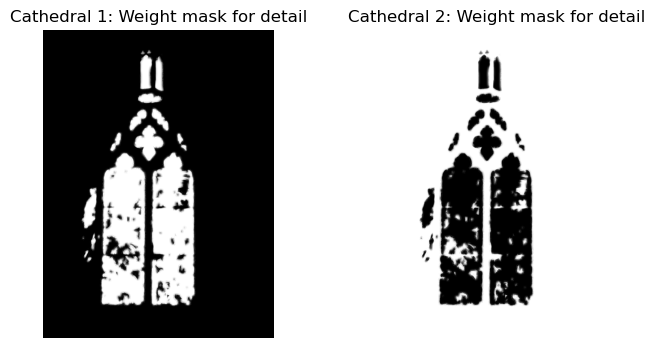

In [29]:
# from cv2.ximgproc import guidedFilter

# # Convert images into uint8
# P1 = np.uint8(255*P1)
# P2 = np.uint8(255*P2)

# # Apply filters
# r1 = 45
# r2 = 7
# eps1 = 0.3
# eps2 = 1e-6
# W1B = np.clip(guidedFilter(im1, P1, r1, eps1), 0, None)
# W2B = np.clip(guidedFilter(im2, P2, r1, eps1), 0, None)
# W1B = np.float32(W1B)/255
# W2B = np.float32(W2B)/255
# W1B = W1B / (W1B + W2B)
# W2B = W2B / (W1B + W2B)
# show_images(W1B, W2B, 'Weight mask for base', 'Weight mask for base', gray=True)
# W1D = np.clip(guidedFilter(im1, P1, r2, eps2), 0, None)
# W2D = np.clip(guidedFilter(im2, P2, r2, eps2), 0, None)
# W1D = np.float32(W1D)/255
# W2D = np.float32(W2D)/255
# W1D = W1D / (W1D + W2D)
# W2D = W2D / (W1D + W2D)
# show_images(W1D, W2D, 'Weight mask for detail', 'Weight mask for detail', gray=True)

### Reconstruction

C:\Users\Theilo\AppData\Local\Temp\ipykernel_22072\985104087.py:3: RuntimeWarning: invalid value encountered in cast
  fusedB = fusedB.astype(int)
C:\Users\Theilo\AppData\Local\Temp\ipykernel_22072\985104087.py:4: RuntimeWarning: invalid value encountered in cast
  fusedD = fusedD.astype(int)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


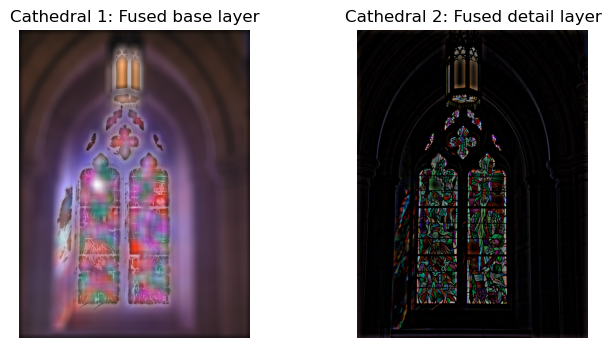

In [24]:
fusedB = W1B[:,:,None] * base1 + W2B[:,:,None] * base2
fusedD = W1B[:,:,None] * detail1 + W2B[:,:,None] * detail2
fusedB = fusedB.astype(int)
fusedD = fusedD.astype(int)
show_images(fusedB, fusedD, 'Fused base layer', 'Fused detail layer')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


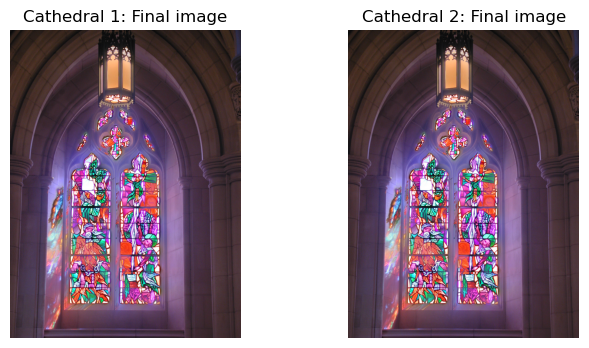

In [25]:
final_img = fusedB + fusedD
show_images(final_img, final_img, 'Final image', 'Final image')